# 2 Wavepackets

In [4]:
import matplotlib.animation as animation;import matplotlib.pyplot as plt; from matplotlib import gridspec
from labellines import labelLines; from celluloid import Camera; import scipy.signal as scs
import scipy.special as ssp; from operator import add; import numpy as np; import random

## Simulation Parameters

In [5]:
nLat = 256; nTime = 32; width0 = 1.; amplitude0 = 0; nWid = 80; nAmp = 80+25

alpha = 8.
nCols = 5
n_cross = 2
nu = 2.*10**(-3)
omega = 0.25 * 50. * 2. * np.sqrt(nu)
delt = np.sqrt(nu / 2.) * (1. + 0.5)
lamb = delt * np.sqrt(2. / nu)
rho = 200. * 2. * np.sqrt(nu) / 2.**3
lenLat = 0.5 * 50. / np.sqrt(2. * nu)
nyq = int(nLat/2)+1
spec = int(nyq/2)
hLat = int(nLat/2)
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
outsize = 4*n_cross*nLat/nTime
dtout = dt*outsize

m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff=',m2eff) 
sigma = 0.15/np.sqrt(m2eff); print('sigma=',sigma)
phi0 = np.pi/2; print('phi0=',phi0)

#Sims = [i for i in range(1, 9)]; print('sim = ', Sims)
width = [width0 + wid * 0.05 / np.sqrt(m2eff) for wid in range(1, nWid+1)]; print('width = ', width)
amplitude = [amplitude0 + np.pi/200. * amp for amp in range(1, nAmp+1)]; print('amplitude = ', amplitude)
mean1 = int(nLat/4 + nLat/10.); mean2 = nLat-mean1; print('means = ', mean1, mean2)
tean1 = int(mean1*nTime/nLat); tean2 = int(mean2*nTime/nLat)
lag = [int(i) for i in range(1, 3)]; print('lag = ', lag)

m2eff= 0.009999999999999997
sigma= 1.5000000000000002
phi0= 1.5707963267948966
width =  [1.5, 2.0, 2.500000000000001, 3.0000000000000004, 3.5000000000000004, 4.000000000000002, 4.500000000000002, 5.000000000000001, 5.500000000000001, 6.000000000000001, 6.500000000000002, 7.000000000000003, 7.500000000000002, 8.000000000000004, 8.500000000000002, 9.000000000000002, 9.500000000000004, 10.000000000000002, 10.500000000000004, 11.000000000000002, 11.500000000000004, 12.000000000000004, 12.500000000000004, 13.000000000000005, 13.500000000000004, 14.000000000000004, 14.500000000000004, 15.000000000000005, 15.500000000000005, 16.000000000000004, 16.500000000000004, 17.000000000000004, 17.500000000000004, 18.000000000000007, 18.500000000000004, 19.000000000000004, 19.500000000000004, 20.000000000000007, 20.500000000000007, 21.000000000000004, 21.500000000000007, 22.000000000000007, 22.500000000000004, 23.000000000000007, 23.500000000000004, 24.000000000000007, 24.500000000000007, 25.00000000000

In [6]:
titles = [r'Field $\phi(x)$', r'Smoothed $\phi(x)$']
file_plots = '/home/dpirvu/collisions/plots/'
plot_sim_suffix = '_for_t'+str(nTime)+'_x'+str(nLat)+'_fields'

## Extract Data from Simulations 

In [7]:
def extract_data(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[2:]]
    infile.close()
    return field_values

def truncateNum(num, decimal_places):
    StrNum = str(num)
    p = StrNum.find(".") + 1 + decimal_places
    return ( StrNum[0:p] )
    
def sim_location(x, y, lag, sim):
    """ x = width, y = amplitude """
    return '/gpfs/dpirvu/collisions/small_fluct_t'+str(nTime)+'_x'+str(nLat)+'_width{:.8f}'.format(x)+'_amp{:.8f}'.format(y)+'_lag'+str(lag)+'_sim'+str(sim)+'_fields.dat'

def sim_suffix(col, x, y, lag, sim):
    return '_col'+str(col)+'_lag'+str(lag)+'_width{:.3f}'.format(x)+'_amp{:.3f}'.format(y)+'_t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields'

def simulation(col, x, y, lag, sim):
    simulation = extract_data(sim_location(x, y, lag, sim), col)
    return np.reshape(simulation, (nTime, nLat))

## Plot Spacetime Diagrams

In [8]:
def plot_data_from_files(col, x, y, lag, sim):
    plt.figure(figsize=(3,3))
    tableau = simulation(col, x, y, lag, sim)
    im = plt.imshow(tableau, aspect='auto', origin='lower')
    plt.title(titles[col]+': wid = {:.3f}'.format(x)+', amp = {:.3f}'.format(y)+', lag = '+str(lag))
    plt.colorbar(im)
    plt.show()
#    plt.savefig(file_plots + 'field' + sim_suffix(col, x, y, lag) + '.png')
    return

def plot_window_from_files(col, x, y, lag, sim):
    plt.figure(figsize=(3, 3))
    field = simulation(col, x, y, lag, sim)[int(nTime/2.) : int(nTime-(tean2-tean1)/2.), int(mean1) : int(mean2)]
    im = plt.imshow(field, aspect='auto', origin='lower', extent=[int(mean1), int(mean2), int(nTime/2.), int(nTime-(tean2-tean1)/2.)])
    plt.title(titles[col]+': wid = {:.3f}'.format(x)+', amp = {:.3f}'.format(y)+', lag = '+str(lag))
    plt.colorbar(im)
    plt.show()
#    plt.savefig(file_plots + 'window_on_field' + sim_suffix(col, x, y, lag) + '.png')
    return

## Mask Field 

In [9]:
def add_mask(col, x, y, lag, sim, threshold):
    masked_field = []
    mask = np.zeros((nTime, nLat))
    field = simulation(col, x, y, lag, sim)
    for i in range(nLat):
        for j in range(nTime):
            if field[j,i] >= np.pi+threshold or field[j,i] <= np.pi-threshold:
                mask[j,i] = 1
    return field * mask

def plot_masked_window(col, x, y, lag, sim, threshold):
    plt.figure(figsize=(3, 3))
    masked_field = add_mask(col, x, y, lag, sim, threshold)[int(nTime/2.) : int(nTime-(tean2-tean1)/2.), int(mean1) : int(mean2)]
    im = plt.imshow(masked_field, aspect='auto', origin='lower', extent=[int(mean1), int(mean2), int(nTime/2.), int(nTime-(tean2-tean1)/2.)])
    plt.xlabel(r'$dx$'); plt.ylabel(r'$dt$')
    plt.title('Masked '+titles[col]+': wid = {:.3f}'.format(x)+', amp = {:.3f}'.format(y)+', lag = '+str(lag))
    plt.colorbar(im)
    plt.show()
#    plt.savefig(file_plots + 'masked_field' + sim_suffix(col, x, y, lag) + '.png')
    return

def find_peak_positions(col, b_size, x, y, lag, sim, timeslice, th):
    """ Finds x coordinate of peaks in smoothened field for mask applied at threshold. """
    field = add_mask(col, x, y, lag, sim, th)[timeslice]
    peak_positions = scs.find_peaks(field, distance = b_size, height = th)[0]
    if field[-1] > 0. and field[0] > 0.:
        if field[0] > field[-1]:
            peak_positions = np.append(field, [0], axis = 0)
        elif field[0] < field[-1]:
            peak_positions = np.append(peak_positions, [nLat-1], axis = 0) # this minds potential boundary discontinuities
    return peak_positions

## Decay Test 

In [12]:
import matplotlib
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid
matplotlib.rcParams.update({'font.size': 20})
import matplotlib as mpl

def decay_test_1wp(col, x, y, lag, threshold):
    counter = 0.
    masked_field = add_mask(col, x, y, lag, 12345, threshold)[-1,:]
    true = np.count_nonzero(masked_field)
    if true > 0.1*nLat:
        counter += 1.
    return counter

def plot_single_wp_trend(col, lagList, threshold):
    fig = plt.subplots(figsize=(9*2, 9))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4,5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharey=ax0)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.subplots_adjust(wspace=.05)
    
    cmap = ListedColormap(["darkblue","yellow"])
    extent = [dx*width[0], dx*width[-1], amplitude[0], amplitude[-1]]

    stats1 = [[decay_test_1wp(col, x, y, lagList[0], threshold) for x in width] for y in amplitude]
    im = ax0.imshow(stats1, aspect='auto', cmap=cmap, origin='lower', extent=extent)
    stats2 = [[decay_test_1wp(col, x, y, lagList[1], threshold) for x in width] for y in amplitude]
    im = ax1.imshow(stats2, aspect='auto', cmap=cmap, origin='lower', extent=extent)

    ax0.set(xlabel = r'$\epsilon$', ylabel = r'$A$')
    ax1.set(xlabel = r'$\epsilon$')

    plt.colorbar(im, ticks = np.arange(2), drawedges='True')
    return  np.count_nonzero(stats1), np.count_nonzero(stats2)

def contour_test(col, x, y, lag, threshold):
    counter = 0
    single_wp_field = add_mask(col, x, y, lag, 12345, threshold)[-1,:]
    if np.count_nonzero(single_wp_field) > 0.1*nLat:
        counter = 1
    return counter

def decay_test(col, x, y, lag, threshold):
    window_size = ( int(nTime-(tean2-tean1)/2.) - int(nTime/2.) ) * (mean2 - mean1)
    counter = 0
    field = add_mask(col, x, y, lag, 5461, threshold)[int(nTime/2.) : int(nTime-(tean2-tean1)/2.), int(mean1) : int(mean2)]
    if np.count_nonzero(field) > 0.1*window_size:
        counter = 1
    return counter

def plot_trend(col, lagList, threshold):
    fig = plt.subplots(figsize=(9*2, 9))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4.3, 5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharey=ax0)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.subplots_adjust(wspace=.05)

    cmap = ListedColormap(["darkblue","yellow"])
    extent = [dx*width[0], dx*width[-1], amplitude[0], amplitude[-1]]
    x, y = np.meshgrid(dx*np.asarray(width), np.asarray(amplitude))

    stats1 = [[decay_test(col, x, y, lagList[0], threshold) for x in width] for y in amplitude]
    ax0.imshow(stats1, aspect='auto', cmap=cmap, origin='lower', extent=extent)
    stats2 = [[decay_test(col, x, y, lagList[1], threshold) for x in width] for y in amplitude]
    im = ax1.imshow(stats2, aspect='auto', cmap=cmap, origin='lower', extent=extent)

    ax0.set(xlabel = r'$\epsilon$', ylabel = r'$A$')
    ax1.set(xlabel = r'$\epsilon$')

    contour1 = [[contour_test(col, x, y, lagList[0], threshold) for x in width] for y in amplitude]
    ax0.contour(x, y, contour1, levels=[0.5, 1.5], colors=('k',), linewidths=(1.5,), origin='lower')
    contour2 = [[contour_test(col, x, y, lagList[1], threshold) for x in width] for y in amplitude]
    ax1.contour(x, y, contour2, levels=[0.5, 1.5], colors=('k',), linewidths=(1.5,), origin='lower')

    plt.colorbar(im, ticks=np.arange(2), drawedges='True')
    return np.count_nonzero(stats1), np.count_nonzero(stats2)

array([3013, 3625])

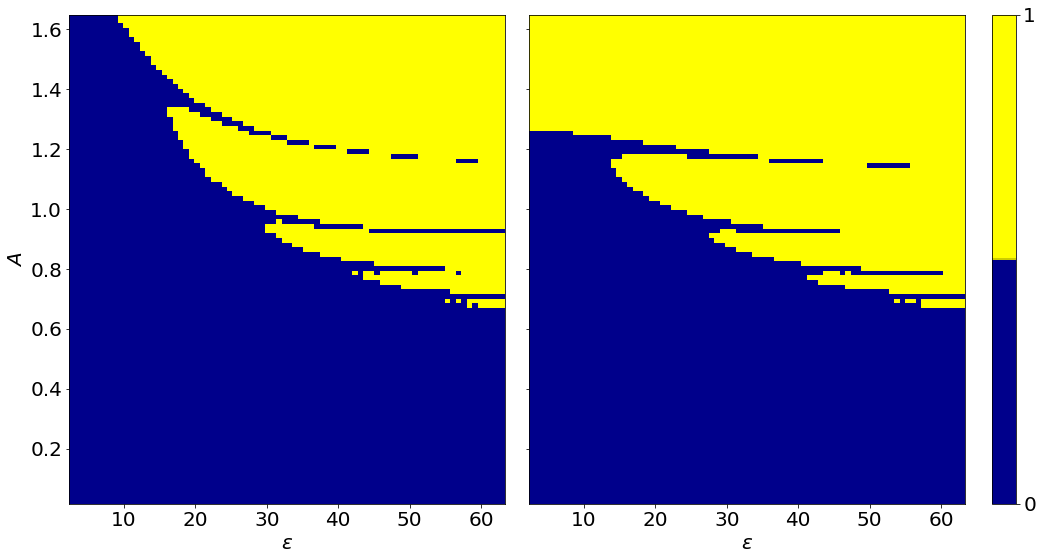

In [13]:
np.asarray(plot_single_wp_trend(0, lag, np.pi/2))

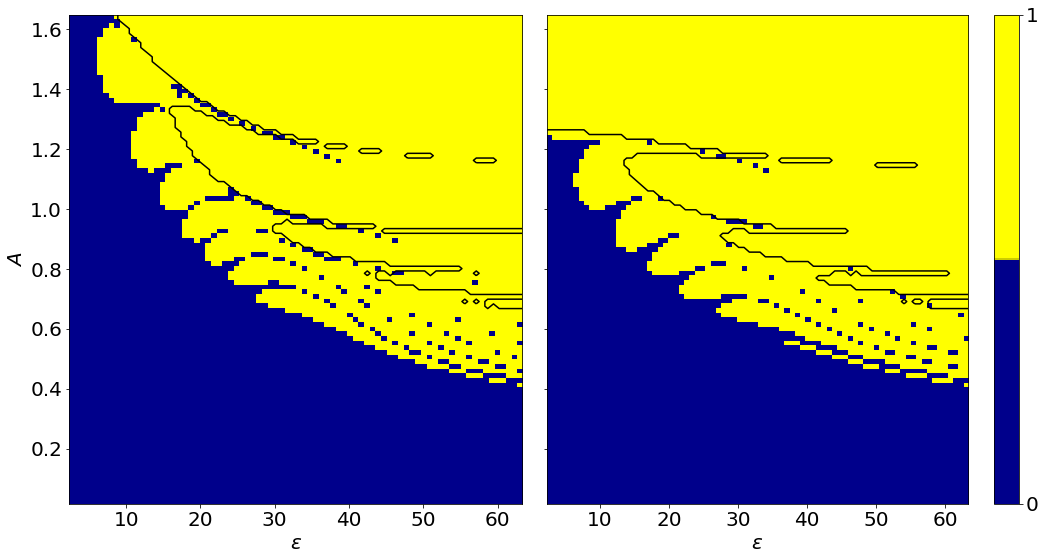

array([4313, 4879])

In [29]:
np.asarray(plot_trend(0, lag, np.pi/2))

In [9]:
len(amplitude)*len(width)

8400